# Active Learning and Uncertainty Sampling

In this exercise we are going to look at uncertainty sampling in the context of classifying flowers from the famous iris dataset. This dataset contains three classes (different species of flowers from the iris family) and four features (measurements of length and width of sepals and petals). This exercise is structured as follows:

- First, you will implement three strategies for uncertainty sampling (least confident, margin, entropy). We start by considering only two classes (and, to be able to visualize the results, we will select only two features as well). In this case, all the strategies should agree on the most uncertain point. Subsequently, we will extent this to three classes and see how this affects the uncertainty estimates.
- Next, you will implement active learning based on these sampling strategies and compare with random sampling (using all features and classes).

The purpose of this exercise is to become familiar with the different strategies for uncertainty sampling and how it can be used in an active learning context.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

# contains some functions for visualizing the results/progress
from exercise_6_iris_utils import *

# plt.style.use('dark_background')

In [24]:
# Helper function
def prepare_data(iris, n_init, use_classes=None, use_features=None, seed=None):
    """Extract classes and features and split data in training, pool, and test
    sets.

    PARAMETERS
    ----------
    iris
        The iris data object.
    use_classes : list | None
        The classes to be used. List of class labels (0, 1, 2) or None for all.
    use_features : list | None
        The features to be used. List of feature indices (0, 1, 2, 3) or None for all.
    n_init : int
        Number of initial data points in the training set.
    seed : int
        Seed for reproducibility.
    """
    X = iris['data']
    y = iris['target']

    # Extract classes and features
    if use_classes is not None:
        use_examples = np.isin(y, use_classes)
        X = X[use_examples]
        y = y[use_examples]
    if use_features is not None:
        X = X[:, use_features]

    n = len(X)
    assert n_init <= n

    # Split in train, pool, and test set
    # Use stratified split to make sure we sample all classes equally
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_init / n, random_state=seed)
    train, pool = next(sss.split(X, y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
    pool_, test = next(sss.split(X[pool], y[pool]))

    return dict(
        train = dict(
            X=X[train],
            y=y[train]
        ),
        pool = dict(
            X=X[pool[pool_]],
            y=y[pool[pool_]]
        ),
        test = dict(
            X=X[pool[test]],
            y=y[pool[test]]
        )
    )

Load the dataset and display the included description.

In [25]:
iris = load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

## Uncertainty With Two or Three Classes

The purpose of this exercise is to familiarize yourself with the uncertainty sampling strategies described in the notes. As a first step, you will need to implement these strategies. The uncertainty is estimated based on the predictive probabilities from the model, i.e., the probability of each class given a data point, and is a matrix with shape (n_points, n_classes) where each row sums to one.


In [26]:
def evaluate_uncertainty(prob, strategy):
    """Evaluate the desired uncertainty sampling strategy on predictive
    probabilities 'prob'.

    PARAMETERS
    ----------
    prob : ndarray 
        numpy array with predictive probabilities of shape 
        (n_points, n_classes)
    strategy : str
        One of 'least confident', 'margin', or 'entropy'.

    The function should return an array with uncertainties of shape
    (n_points, ) corresponding to the desired strategy.
    """
    # [your code here]
    if strategy == 'least confident':
        res = 1 - prob.max(1)
    elif strategy == 'margin':
        ix = np.arange(len(prob))
        p2, p1 = prob.argsort(1)[:, -2:].T
        res = 1 - (prob[ix, p1] - prob[ix, p2])
    elif strategy == 'entropy':
        res = - np.sum(prob * np.log2(prob), axis=1)
    else:
        raise ValueError
    return res

Now that we have a function to compute the different uncertainty metrics, we are going to examine them in more detail. Below we are going to

- prepare the data,
- fit the model on the training data,
- compute predictive probabilities, and
- compute the uncertainty estimates associated with these probabilities.

The predictive probabilities can be evaluated using the `predict_proba` method of the `LogisticRegression` class. Finally, we plot the results (please ignore the colorbar on the top left subplot).

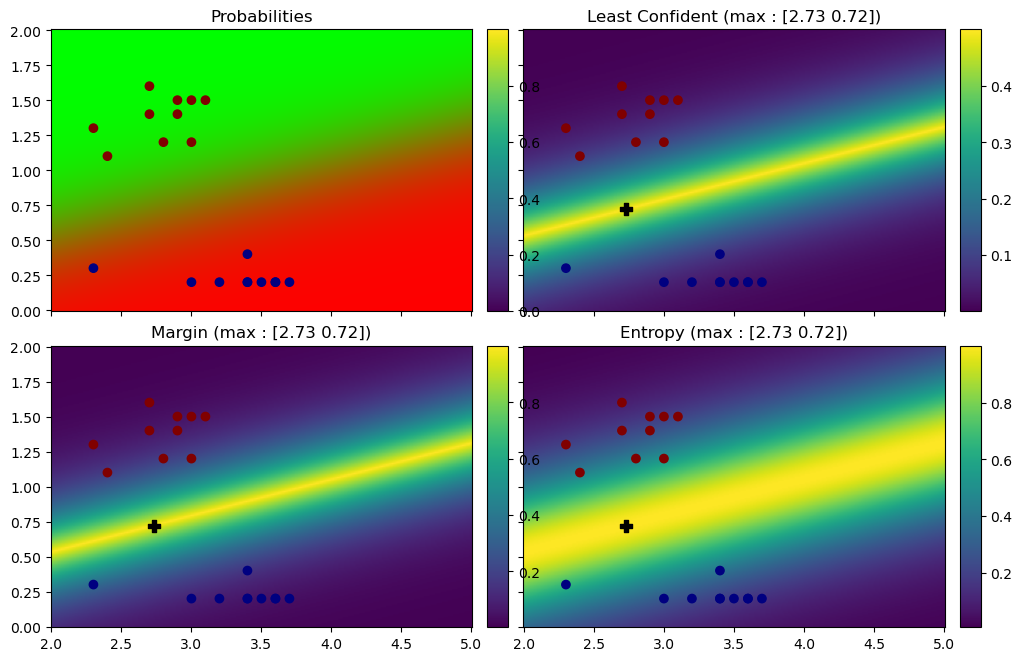

In [27]:
# Settings
n_init = 20             # Number of points to use for fitting the model
use_classes = [0, 1]    # None (all three classes or a list of class labels to use, e.g., [0, 1])
use_features = [1, 3]   # The two features to use. Should be in the set (0, 1, 2, 3)
seed = 0

# Prepare the data (extract and split)
data = prepare_data(iris, n_init, use_classes, use_features, seed=seed)

# Fit a logistic classifier
# (While testing this code I experienced some issues with the default
# solver (lbfgs) which is why I use different one here.)
model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear', random_state=seed)
model = model.fit(data['train']['X'], data['train']['y'])

# For the sake of visualization, we are going to create a grid on
# which to evaluate probabilities and uncertainties
grid, imshow_kwargs = make_grid(data['train']['X'], data['pool']['X'])
pool = grid.transpose(1,2,0).reshape(-1, len(use_features))

# Evaluate uncertainties on the `pool` variable

# [your code here]
prob = model.predict_proba(pool)


least_confident = evaluate_uncertainty(prob, 'least confident')
margin = evaluate_uncertainty(prob, 'margin')
entropy = evaluate_uncertainty(prob, 'entropy')

# Once calculated, plot the uncertainty metrics
plot_grid(prob, least_confident, margin, entropy, data, grid, imshow_kwargs)

In the figure above, filled circles represent data points used to fit the model. Hollow circles are the data points in the pool (i.e., points which we could potentially query). Points are colored according to their *true* label. The bold black cross shows which point each sampling strategy suggests to query next. 
- (top left) The posterior probabilities plotted as RGB (in the case of two classes, blue is unused).
- (top right) Least confidence.
- (bottom left) Margin.
- (bottom right). Entropy.

Go back and do the same using all three classes (`use_classes = None`). You can also try to use different pairs of features.

Using three classes, the strategies should no longer agree completely on which point to sample next. Do some of them tend to agree more than others? Why?

[your answer here]

Are there other things which might be important to consider besides how uncertain the model is about the label of a given point? For example, your might consider whether these sampling strategies tend to suggest points similiar to those you would have chosen yourself?

[your answer here]

What kind of sampling scenario does this emulate? What scenario are we actually dealing with with this dataset?

[your answer here]

## Active Learning and Random Sampling

Up until now we simply extracted a random subset of the data, used this to train the model, and evaluated probabilities and uncertainties. This enabled us to determine which point to sample next, however, we did not actually do this. As such, we have not done any 'active' learning yet. Thus, your task is now to integrate this into an activate learning scenario. Basically, this involves the following steps

- Choose some initial data points (training set)
1. Fit the model
2. Evaluate probabilities on the pool
3. Evaluate corresponding uncertainties
4. Update training set (and pool) based on the sampled point
5. Return to step 1 and repeat for some number of iterations

To track the progress you will probably also want to evaluate performance (accuracy) on a test set. This can be done using the `score` method of the model. You should also implement a random sampling approach so that we may compare the two approaches. Finally, plot the classification accuracy of both methods against the number of data available when training the model/number of iterations. One thing to note is that in order to get a stable estimate of the error, you might need to average several runs/model fits so it might be an idea to group these things into functions to easily run them multiple times.

For this exercise you should use all classes and all features, however, if you would like to plot the results, you can extract two features and plot the results in the that subspace. You can use the function `plot_pool` to plot the uncertainties for a few iterations (along with the selected point to sample next). (This should be called between step 3 and 4.)

> Define a function for fitting the model using either active learning (with one of the uncertainty sampling strategies) or random sampling.

Here we provide
- a helper function to update the training set and pool and
- a skeleton for fitting the model,
however, feel free to ignore this and create your own from scratch if you do not find it helpful.

In [28]:
def update_data(data, idx):
    """Update of the data dictionary from `prepare_data` by moving the data
    point with index `idx` from the pool to the training set."""
    data['train']['X'] = np.append(data['train']['X'], np.atleast_2d(data['pool']['X'][idx]), axis=0)
    data['train']['y'] = np.append(data['train']['y'], np.atleast_1d(data['pool']['y'][idx]), axis=0)    
    data['pool']['X'] = np.delete(data['pool']['X'], idx, axis=0)
    data['pool']['y'] = np.delete(data['pool']['y'], idx, axis=0)

def fit_model(iris, paradigm, strategy, n_init, n_iterations, use_classes=None, use_features=None, plot=False):
    """Run `n_iterations` of active learning or random sampling.
    
    PARAMETERS
    ----------
    iris :
        The iris dataset object.
    paradigm : str
        One of 'active learning' or 'random'.
    strategy : str
        The uncertainty strategy to use (only used when paradigm = 
        'active learning').
    n_init : int
        The initial number of points in the training set.
    n_iterations : int
        The number of iterations to run.
    use_classes, use_features (same as for prepare_data)
    plot : bool
        Whether to plot the state at each iteration (see the
        description of plot_pool). It is probably a good idea to
        set `n_iterations` low when this is True. You can include
        
            if plot:
                plot_pool(data, idx, uncertainty)
        
        in between steps 3 and 4. Otherwise, feel free to ignore this
        argument.

    RETURNS
    ----------
    scores : ndarray
        The score at each iteration.    
    """
    # Initialize
    data = prepare_data(iris, n_init, use_classes, use_features)
    scores = np.zeros(n_iterations)
    model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear', warm_start=True)

    # Do active learning for `n_iterations` by executing the steps listed above
    
    # [your code here]
    for i in range(n_iterations):
        # 1 Fit
        model: LogisticRegression = model.fit(data['train']['X'], data['train']['y'])

        # 2 Eval model on pool
        prob = model.predict_proba(data['pool']['X'])
        scores[i] = model.score(data['test']['X'], data['test']['y'])

        # 3 Eval uncertainty on pool
        if i < n_iterations:
            if paradigm == 'active learning':
                uncertainty = evaluate_uncertainty(prob, strategy)
                if strategy in ('least confident', 'entropy'):
                    idx = uncertainty.argmax()
                elif strategy == 'maximum margin':
                    idx = uncertainty.argmin()
                else:
                    raise ValueError
            elif paradigm == 'random':
                uncertainty = None
                idx = np.random.choice(np.arange(len(data['pool']['X'])))
            else:
                raise ValueError
            if plot:
                plot_pool(data, idx, uncertainty)
            # 4 Update training set and pool
            update_data(data, idx)
    return scores

> Run active learning and random sampling for a certain number of iterations. Repeat this a certain number of times, average the result, plot the two results (training set size vs. classification error) and compare.

Text(0, 0.5, 'Classification Accuracy')

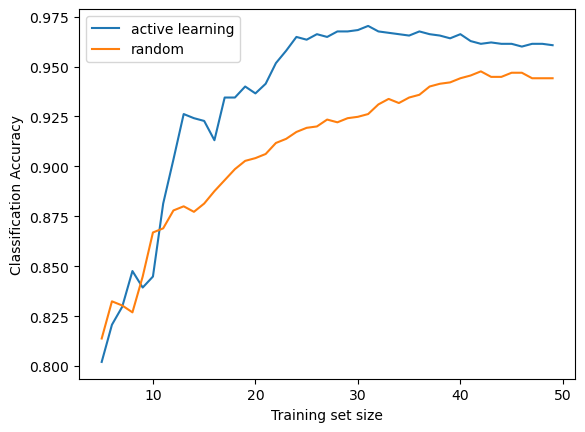

In [29]:
# Settings
n_init = 5
n_iterations = 50 - n_init
n_avg = 50

# Average `n_avg` fits
scores_al = np.zeros((n_avg, n_iterations))
scores_rn = np.zeros((n_avg, n_iterations))

# [your code here]
for i in range(n_avg):
    scores_al[i] = fit_model(iris, 'active learning', 'entropy', n_init, n_iterations)
    scores_rn[i] = fit_model(iris, 'random', 'entropy', n_init, n_iterations)

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(n_init, n_iterations+n_init), scores_al.mean(0))
ax.plot(np.arange(n_init, n_iterations+n_init), scores_rn.mean(0))
ax.legend(['active learning', 'random'])
ax.set_xlabel('Training set size')
ax.set_ylabel('Classification Accuracy')

In [30]:
# Illustration of the state at each iteration before the next point is added to the training set
# (active learning and random sampling)
# (Of course this will only work if you implemented the `plot_pool` feature of `fit_model`)
n_init = 10
n_iterations = 3

active learning (entropy)


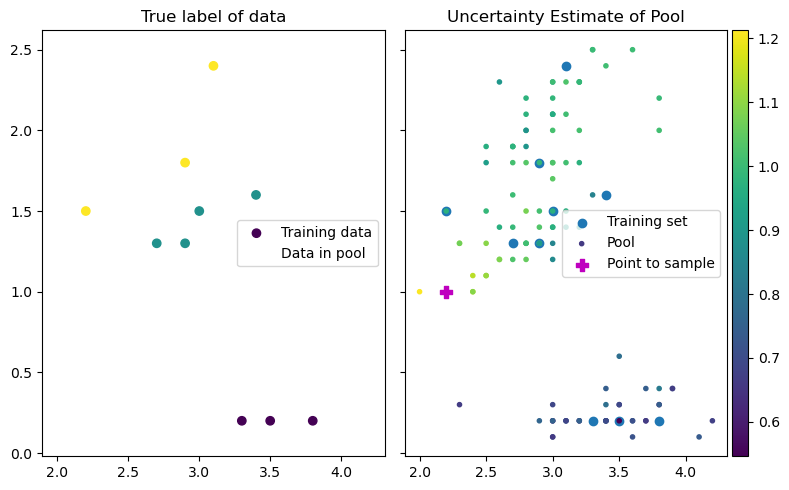

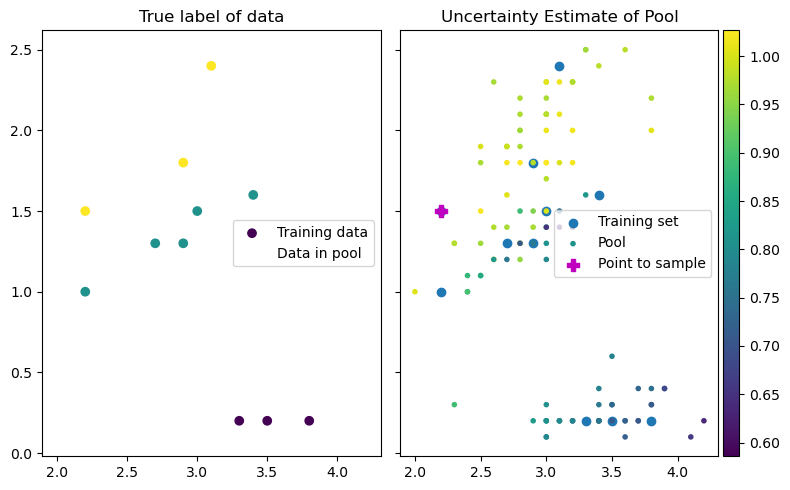

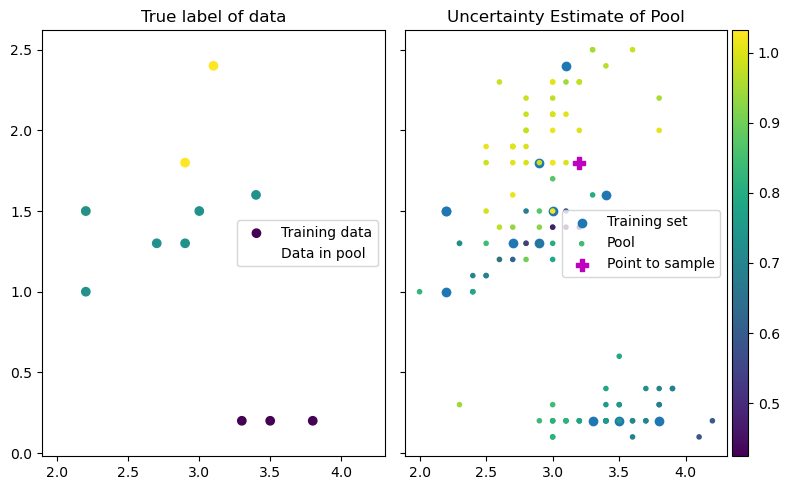

In [31]:
print('active learning (entropy)')
_ = fit_model(iris, 'active learning', 'entropy', n_init, n_iterations, plot=True)

random sampling


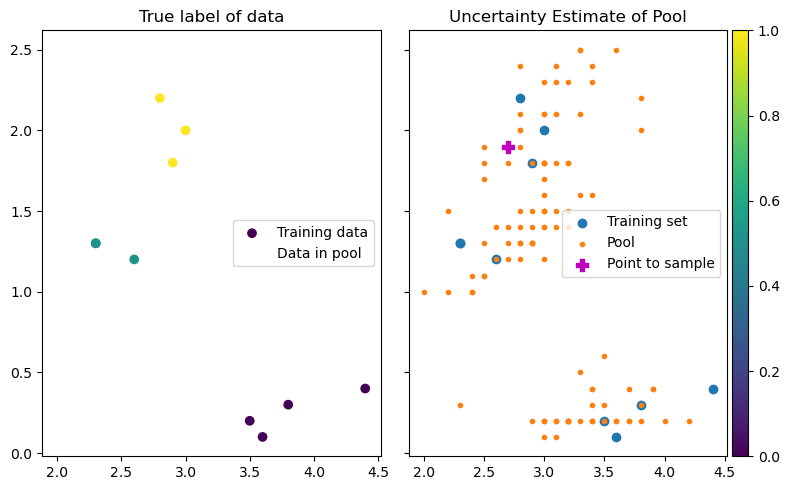

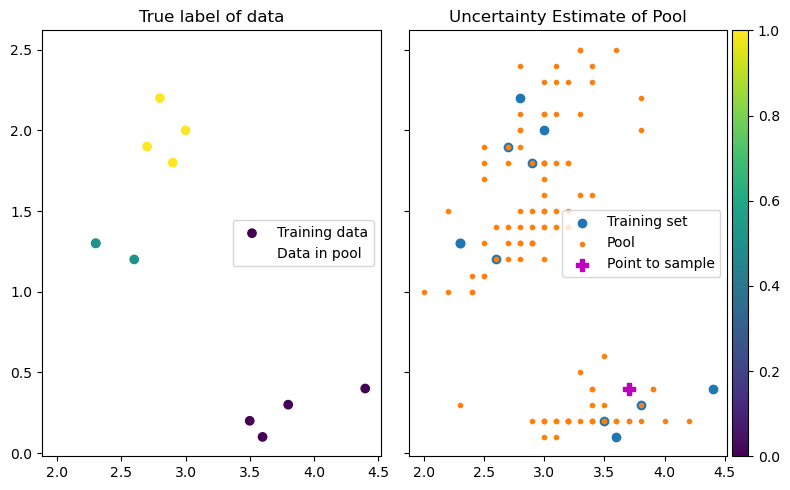

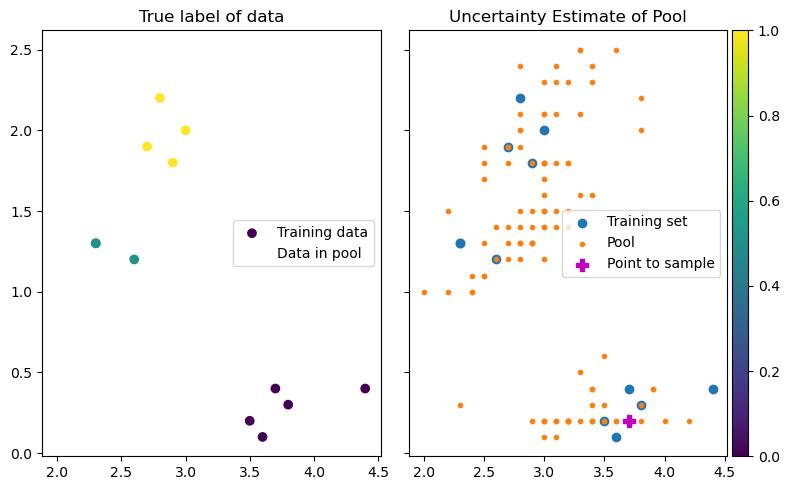

In [32]:
print('random sampling')
_ = fit_model(iris, 'random', 'entropy', n_init, n_iterations, plot=True)

A few things you may want to consider.

To get a stable estimate of the performance you will probably need to average several runs of active learning and random sampling. What could be the reason (or a reason) for that? You can try to look into the `warm_start` argument of the `LogisticRegression` class and see if that makes a difference.

The dataset is small, so how we handle the data affects the initial iterations.

Do active learning seem to make a difference for this particular problem? How does settings like number of initial points used and number of queries from the pool affect this?

[your answer here]

## Adding Density Weighting
As a final thing, let us have a brief look at how density weighting might affect which point we select. As this data set do not really contain any outliers, we will again be working with a grid of points to illustrate the idea. First, let us set up the experiment (similar to the first exercise).

In [33]:
# Settings
n_init = 20           # Number of points to use for fitting the model
use_classes = None    # None (all three classes or a list of class labels to use, e.g., [0, 1])
use_features = [1, 3] # The two features to use. Should be in the set (0, 1, 2, 3)
seed = 0

# Prepare the data (extract and split)
data = prepare_data(iris, n_init, use_classes, use_features, seed=seed)

# Fit a logistic classifier
# (While testing this code I experienced some issues with the default
# solver (lbfgs) which is why I use different one here.)
model = LogisticRegression(penalty='l2', C=1e1, solver='liblinear', random_state=seed)
model = model.fit(data['train']['X'], data['train']['y'])

# For the sake of visualization, we are going to create a grid on
# which to evaluate probabilities and uncertainties
grid, imshow_kwargs = make_grid(data['train']['X'], data['pool']['X'])
pool = grid.transpose(1,2,0).reshape(-1, len(use_features))

# Compute the predictive probabilities
prob = model.predict_proba(pool)

Implement the two similarity metrics from the notes (cosine angle and radial basis function, RBF).

- Normally, we would calculate the average similarity between all points in the pool, however, for visualization purposes, we have created a grid of points which serves as our "pool" (although these points do not exist in the data set). Thus, `compute_similarity` should calculate the average similarity between the grid points (the `pool` variable) and the points in the actual pool (`data["pool"]["X"]`) and return a vector of shape `len(pool)`.
- To calculate the RBF you can use the `cdist` function from `scipy.spatial.distance` (already imported).

In [34]:
def compute_similarity(pool, data, metric):
    """Return the average similarity of each point in `pool` to the points in
    data['pool']['X'].
    
    pool : (n, d) where n is the number of points on the grid and d is the
        number of features.
    data : dict containing `pool`.
    metric : str
        'cosine angle' or 'rbf'.    
    """
    # [your code here]
    if metric == 'cosine angle':
        sim = pool / np.linalg.norm(pool, axis=1, keepdims=True) @ (data['pool']['X'] / np.linalg.norm(data['pool']['X'], axis=1, keepdims=True)).T
    elif metric == 'rbf':
        sim = np.exp(-cdist(pool, data['pool']['X'])**2 / pool.shape[1])
    else:
        raise ValueError
    return sim.mean(1)

Below we plot, one of the uncertainty metrics together with the similarity metrics and the combined (i.e., density weighted) metric.

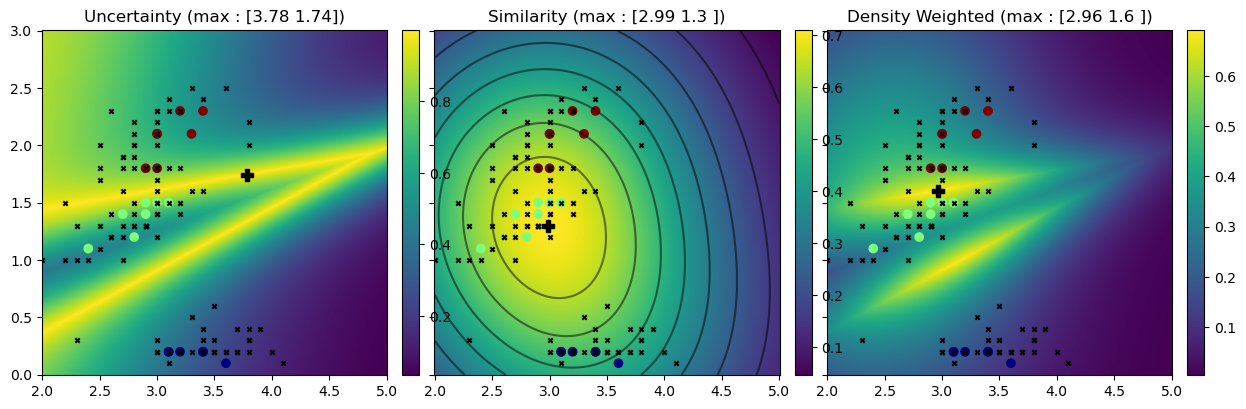

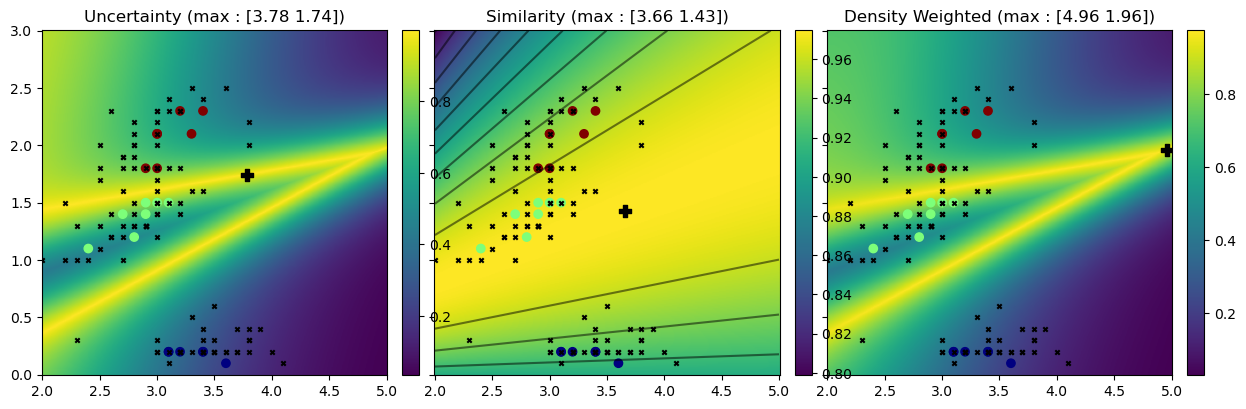

In [35]:
beta = 1 # the parameter controlling the relative importance of uncertainty and similarity
uncertainty = evaluate_uncertainty(prob, 'margin')
sim = compute_similarity(pool, data, 'rbf')
plot_grid_dw(uncertainty, sim, beta, data, grid, imshow_kwargs)
sim = compute_similarity(pool, data, 'cosine angle')
plot_grid_dw(uncertainty, sim, beta, data, grid, imshow_kwargs)

Here the black x's denote the points in the actual pool, i.e., those we used for calculating similarities, and the colored circles are samples from the different classes.

Which of the similarity metrics seem to work best in this case? Does density weighting make sense in this classification setting? Does it depend on the uncertainty metric used?

The RBF works best, as it describes the data more appropriately. In this case, density weighting makes sense since we see that it is placed at an appropriate location, while for cosine angle that and similarity does not make any sense.